In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U
import matplotlib.pyplot as plt
import numpy as np

In [3]:
omp = 1
mpi_run = 'mpirun -np 8'

# DFT analysis of GaAs

This notebook contains the analysis of the GaAs (with SO interaction) performed with QuantumESPRESSO. In particular

* GS convergence for the energy cutoff, the number of kpoints and the equilibrium lattice constant
* Plot of the band structure along a path and determination of the value of the scissor nedded to set the gap to 1.42 eV, that correspond
   to the experimental value at 300 K.
* NSCF computations performed on various kpoints samplings, needed for the subsequent RT analysis.
* Analysis of the Dos
* Analysis of the JDos

## GS convergence analysis

In [4]:
run_dir = 'GS_convergence'

We define a basic input object

In [5]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'lspinorb': '.true.',
  'noncolin': '.true.'},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_rel.pz-rrkj3.UPF'],
  'As': ['1.0', 'As_rel.pz-rrkj3.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

We perform a first seek_convergence procedure using the cutoff energy of the wave functions as free parameter.
In this case we set the kpoints sampling on a grid 4,4,4

In [6]:
kvalue = 4
inp.set_kpoints(type='automatic',points=[kvalue,kvalue,kvalue])

We start with the value of 80 as suggested in the specifications of the pseudos (minum allowed is 76 Ry for As)

In [7]:
ecut = [10*i for i in range(8,11)]
ecut

[80, 90, 100]

In [8]:
ecut_conv = D.Dataset(run_dir=run_dir)

In [9]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)
#code.global_options()

Initialize a serial QuantumESPRESSO calculator with scheduler direct


In [10]:
for e in ecut:
    idd = {'ecut' : e, 'k' : kvalue}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_energy_cutoff(e)
    ecut_conv.append_run(id=idd,input=inp,runner=code)

We use a postProcessing function to extract the total energy from the results and run a seek_convergence

In [11]:
ecut_conv.set_postprocessing_function(D.QE_get_energy)

In [12]:
ecut_conv.seek_convergence(rtol=1e-5)

Fetching results for id " {'ecut': 80, 'k': 4} "
Create the sub-directory 'GS_convergence'
Executing command: cd GS_convergence; mpirun -np 8 pw.x -inp ecut_80-k_4.in > ecut_80-k_4.log
run0_is_running:True  
run0_is_running:True  
Job completed
Fetching results for id " {'ecut': 90, 'k': 4} "
Executing command: cd GS_convergence; mpirun -np 8 pw.x -inp ecut_90-k_4.in > ecut_90-k_4.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed
Convergence reached in Dataset "Dataset" for id " {'ecut': 80, 'k': 4} "


({'ecut': 80, 'k': 4}, -8.657253103634728)

In [13]:
ecut_conv = 80

The choice ecut = 80 guarantees a convergence of the gs with a rtol of 1e-5, that corresponds to 0.1 meV.

We perform a second seek_converge on the value of k.

In [14]:
kvalue_conv = D.Dataset(run_dir=run_dir)

In [15]:
inp.set_energy_cutoff(ecut_conv)

In [16]:
kvalues = [4,5,6,7,8]

In [17]:
for k in kvalues:
    idd = {'ecut' : ecut_conv, 'k' : k}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,k])
    kvalue_conv.append_run(id=idd,input=inp,runner=code)

In [18]:
kvalue_conv.set_postprocessing_function(D.QE_get_energy)

In [19]:
kvalue_conv.seek_convergence(rtol=1e-4)

Fetching results for id " {'ecut': 80, 'k': 4} "
Skip the computation for input ecut_80-k_4
Job completed
Fetching results for id " {'ecut': 80, 'k': 5} "
Executing command: cd GS_convergence; mpirun -np 8 pw.x -inp ecut_80-k_5.in > ecut_80-k_5.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed
Fetching results for id " {'ecut': 80, 'k': 6} "
Executing command: cd GS_convergence; mpirun -np 8 pw.x -inp ecut_80-k_6.in > ecut_80-k_6.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed
Fetching results for id " {'ecut': 80, 'k': 7} "
Executing command: cd GS_convergence; mpirun -np 8 pw.x -inp ecut_80-k_7.in > ecut_80-k_7.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  


({'ecut': 80, 'k': 6}, -8.66322870362442)

We choose k = 6 that guarantees convergence at the order of 1meV

In [20]:
k_conv = 6

Lastly, we seek for the equilibrium lattice constants

In [21]:
lat_conv = D.Dataset(run_dir=run_dir)

In [22]:
lat0 = 10.5
scale = 5e-3
deltas = [i for i in range(-3,3)]

In [23]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])

In [24]:
for delta in deltas:
    idd = {'lat_delta' : delta}
    inp.set_prefix(D.name_from_id(idd))
    lat = lat0*(1+delta*scale)
    inp.set_lattice(2,celldm1=lat)
    lat_conv.append_run(id=idd,input=inp,runner=code)

In [27]:
lat_conv.set_postprocessing_function(D.QE_get_energy)

In [28]:
results = lat_conv.run()

Skip the computation for input lat_delta_-3
Job completed
Skip the computation for input lat_delta_-2
Job completed
Skip the computation for input lat_delta_-1
Job completed
Skip the computation for input lat_delta_0
Job completed
Skip the computation for input lat_delta_1
Job completed
Skip the computation for input lat_delta_2
Job completed


We perform a quadratic fit of data

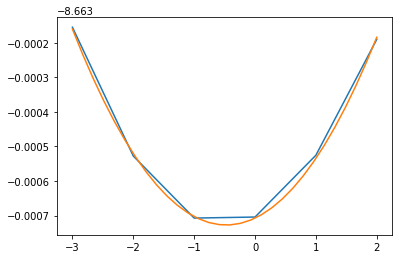

In [29]:
res = [results[i] for i in range(len(deltas))]
coeffs = np.polyfit(deltas,res,2)
values_fit = np.linspace(deltas[0],deltas[-1],30)
res_fit = [coeffs[0]*x**2+coeffs[1]*x+coeffs[2] for x in values_fit]
plt.plot(deltas,res)
plt.plot(values_fit,res_fit)

In [31]:
delta_eq = -coeffs[1]/(2*coeffs[0])
lat_eq = lat0*(1+delta_eq*scale)
lat_eq

10.475140702462957

This is the value of the equilibrium lattice constants. So to summarize

In [188]:
ecut_conv = 80
k_conv = 6
lat_eq = 10.475

We perform a last scf computation for the converged system, that will be used as starting point for the nscf ones

In [40]:
inp.set_lattice(2,celldm1=lat_eq)
prefix = 'gs_converged'
inp.set_prefix(prefix)
#inp

In [35]:
code.run(run_dir=run_dir,inputs=[inp],names=[prefix])

Executing command: cd GS_convergence; mpirun -np 8 pw.x -inp gs_converged.in > gs_converged.log
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
run0_is_running:True  
Job completed


{'output': ['GS_convergence/gs_converged.save/data-file-schema.xml']}

# Analysis of the band structure

In [189]:
run_dir = 'QE_bands'

We compute the band structure along a path. We use the converged energy_cutoff and lattice parameters.

In [190]:
hsp = U.high_sym_fcc
klist = U.build_kpath(hsp['L'],hsp['G'],hsp['X'],hsp['K'],hsp['G'],numstep=30)
klist

[[0.5, 0.5, 0.5, 30],
 [0.0, 0.0, 0.0, 30],
 [0.0, 0.0, 1.0, 30],
 [0.0, 1.0, 1.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [191]:
pref = 'bands' 

inp = I.PwInput()
inp.set_bands(16,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp.set_prefix(pref)
#inp

In [192]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)

Initialize a serial QuantumESPRESSO calculator with scheduler direct


In [193]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir='GS_convergence/gs_converged.save')

The folder QE_bands/bands.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bands
Job completed


In [194]:
bands = U.BandStructure.from_Pw(result['output'][0],hsp,set_gap=1.42)

Apply a scissor of 0.5446695074337246 eV


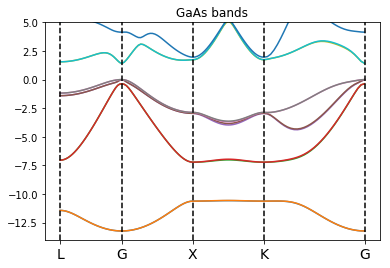

In [197]:
plt.title('GaAs bands')
plt.ylim(-14,5)
bands.plot(plt,selection=[i for i in range(0,11)])

It is useful also to display the band structure evidencing the region around $\Gamma$ that is sampled for the RT analysis

In [36]:
hs_positions = bands.get_high_sym_positions()
hs_positions

(['G', 'G', 'X', 'L', 'K'],
 [0.8660254037844385,
  4.28023896615753,
  1.8660254037844377,
  0.0,
  2.866025403784435])

In [37]:
kspan = 0.13 #in unit of 2pi/alat
k0 = hs_positions[1][0]
k0

0.8660254037844385

/home/marco/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0.0, 2)

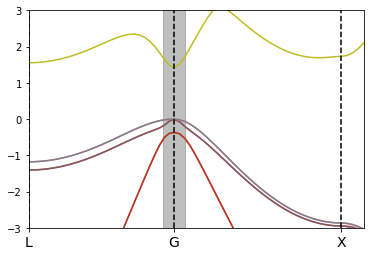

In [45]:
bands.plot(plt,selection=[i for i in range(0,9)])
ax = plt.axes()
ax.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
plt.ylim(-3,3)
plt.xlim(0.,2)

## NSCF computation on various grids

We perform nscf computations on grids of various dimensions and type. These computations will be the starting points for various
RT analysis, to the effects of the kpoints sampling in the real-time reponse of the systems. 

All the computations share the same scf input. The common parameters are

In [4]:
run_dir = 'NSCF'

In [5]:
ecut_conv = 80
k_conv = 6
lat_eq = 10.475
source_dir = 'GS_convergence/gs_converged.save'
num_bands = 16

In [6]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,skip=True,multiTask=False)

Initialize a serial QuantumESPRESSO calculator with scheduler direct


The basic input file is given by

In [7]:
inp = I.PwInput()
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
#inp

### Regular grid

In [8]:
kpoints = 8

In [9]:
idd = {'bnds' : num_bands, 'kpoints' : kpoints}
pref = D.name_from_id(idd)
inp.set_kpoints(type='automatic',points=[kpoints,kpoints,kpoints])
inp.set_prefix(pref)
#inp

In [10]:
result_reg = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_reg

The folder NSCF/bnds_16-kpoints_8.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bnds_16-kpoints_8
Job completed


{'output': ['NSCF/bnds_16-kpoints_8.save/data-file-schema.xml']}

### Gamma

In [11]:
klist = [[0.0,0.0,0.0,1.0]]

In [12]:
idd = {'bnds' : num_bands, 'sampling' : 'gamma'} 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [13]:
result_gamma = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_gamma

The folder NSCF/bnds_16-sampling_gamma.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bnds_16-sampling_gamma
Job completed


{'output': ['NSCF/bnds_16-sampling_gamma.save/data-file-schema.xml']}

### Random grid

In [14]:
import random as rand
num_kpoints =  100
k_span = 0.13
weight = [1.]

In [15]:
klist = []
klist.append([0.,0.,0.]+weight) #we include Gamma
for n in range(num_kpoints-1):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + weight
    klist.append(k_rand)

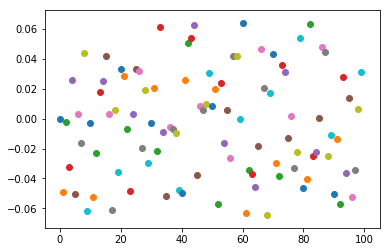

In [16]:
for ind,k in enumerate(klist):
    plt.scatter(ind,k[0])

In [17]:
idd = {'bnds' : num_bands, 'kpoints' : num_kpoints, 'sampling' : 'random'}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [18]:
result_random = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_random

The folder NSCF/bnds_16-kpoints_100-sampling_random.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bnds_16-kpoints_100-sampling_random
Job completed


{'output': ['NSCF/bnds_16-kpoints_100-sampling_random.save/data-file-schema.xml']}

## Analysis of the Dos

We can compare the Dos associated to the regular grid sampling with the one related to the random sampling in the region 
close to $\Gamma$.

In [19]:
dos = U.Dos.from_Pw(result_reg['output'][0],set_gap=1.42,eta=0.05,label='reg',minVal=-4,maxVal=4)

Apply a scissor of 0.5446694952016056 eV


In [20]:
dos.append_fromPw(result_random['output'][0],label='rand',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.544669489344803 eV


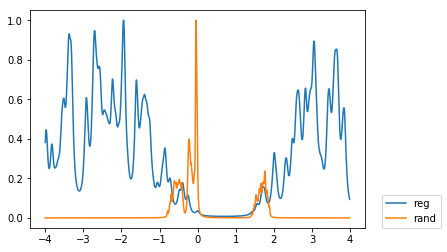

In [21]:
%matplotlib inline
dos.plot(plt,rescale=True,include=[0,1])
plt.legend(loc=(1.05,0))

## Analysis of the JDos

We analyze the JDos

In [130]:
from mppi import Parsers as P

In [131]:
r_reg = P.PwParser(result_reg['output'][0])
r_rand = P.PwParser(result_random['output'][0])

Parse file : NSCF/bnds_16-kpoints_8.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random.save/data-file-schema.xml


In [132]:
r_reg.get_evals()[0:2]

array([[-1.32281603e+01, -1.32281603e+01, -3.67006000e-01,
        -3.67005999e-01, -5.11555331e-09, -3.65466057e-09,
        -3.25534977e-09,  0.00000000e+00,  8.75330505e-01,
         8.75330530e-01,  3.59530100e+00,  3.59530105e+00,
         3.80415834e+00,  3.80415835e+00,  3.80415836e+00,
         3.80415840e+00],
       [-1.30475595e+01, -1.30475594e+01, -2.08010072e+00,
        -2.08010072e+00, -4.84237874e-01, -4.84237873e-01,
        -2.50227735e-01, -2.50227733e-01,  1.78845162e+00,
         1.78845163e+00,  4.03515777e+00,  4.03515779e+00,
         4.18612080e+00,  4.18612081e+00,  4.26701579e+00,
         4.26701585e+00]])

In [133]:
r_reg.evals[3]

array([-0.23668525, -0.23668525, -0.03113573, -0.03113573,  0.15114312,
        0.15114312,  0.1595124 ,  0.1595124 ,  0.24043005,  0.24043005,
        0.36798488,  0.36798488,  0.37216263,  0.37216263,  0.48816904,
        0.48816905])

In [134]:
r_reg.nbands

16

In [139]:
r_rand.get_transitions(initial=[8,9],final=[8,9])[0]

[8, 9] [8, 9]


array([6.55920305e-08])

In [140]:
weights = r_rand.weights

In [156]:
transitions = r_rand.get_transitions(set_gap=1.42,initial=[2,3,4,5,6,7],final=[8,9])

[2, 3, 4, 5, 6, 7] [8, 9]
Apply a scissor of 0.544669489344803 eV


In [157]:
dos = U.Dos()
dos.append_fromPwData(transitions,weights,minVal=0,maxVal=4,eta=0.005)

Text(0.5,1,'JDos cv')

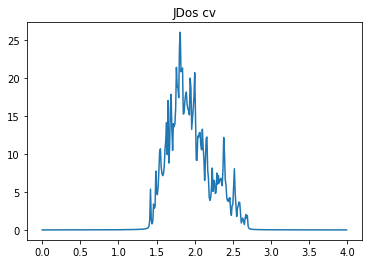

In [159]:
dos.plot(plt)
plt.title('JDos cv')

Analyze the cc' transitions (in meV)

In [198]:
transitions = 1e3*r_rand.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Apply a scissor of 0.544669489344803 eV


In [199]:
#transitions

Text(0.5,0,'energy (meV)')

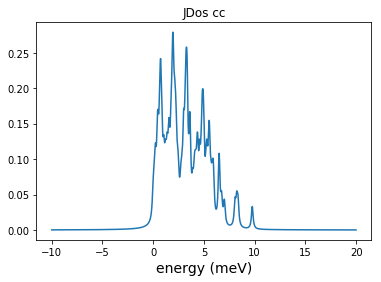

In [236]:
dos.plot(plt)
plt.title('JDos cc')
plt.xlabel('energy (meV)',size=14)

In [ ]:
###########################################

In [101]:
from mppi import Parsers as P

In [102]:
r_reg = P.PwParser(result_reg['output'][0])
r_rand = P.PwParser(result_random['output'][0])

Parse file : NSCF/bnds_16-kpoints_8.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random.save/data-file-schema.xml


In [103]:
r_reg.get_gap()

Direct gap system
Gap : 0.8753305047983944 eV


{'gap': 0.8753305047983944,
 'direct_gap': 0.8753305047983944,
 'position_cbm': 0,
 'positon_vbm': 0}

In [104]:
r_rand.get_gap()

Direct gap system
Gap : 0.875330510655197 eV


{'gap': 0.875330510655197,
 'direct_gap': 0.875330510655197,
 'position_cbm': 0,
 'positon_vbm': 0}

In [108]:
r_reg.kpoints[0]

[0.0, 0.0, 0.0]